## Seminar 4. Deep Learning



Let's start by downloading the standard libraries and functions.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt
import time
%matplotlib inline
# Fix the seed and the random state
seed=42
random_state=42

# 1. Quadrilateral classification of convexity

We will generate $10^5$ examples of 4 vertices, stored as a coordinates.

In [80]:
def order_points_clockwise(pts):
    center = np.mean(pts, axis=0)
    angles = np.arctan2(pts[:,1] - center[1], pts[:,0] - center[0])
    return pts[np.argsort(angles)]

def is_convex_quad(points):
    points = np.array(points)
    points = order_points_clockwise(points)
    def cross(a, b, c):
        ab = (b[0] - a[0], b[1] - a[1])
        bc = (c[0] - b[0], c[1] - b[1])
        return ab[0] * bc[1] - ab[1] * bc[0]

    signs = []
    n = 4
    for i in range(n):
        a, b, c = points[i], points[(i + 1) % n], points[(i + 2) % n]
        z = cross(a, b, c)
        signs.append(np.sign(z))

    signs = [s for s in signs if s != 0]
    return all(s > 0 for s in signs) or all(s < 0 for s in signs)


def generate_quadrilateral_dataset(n_samples=1000, xy_range=(-10, 10), random_state=None):
    if random_state:
        np.random.seed(random_state)

    data = []
    for _ in range(n_samples):
        points = np.random.uniform(xy_range[0], xy_range[1], size=(4, 2))
        label = int(is_convex_quad(points))
        flat_points = points.flatten().tolist()
        data.append(flat_points + [label])

    columns = [f'{coord}{i+1}' for i in range(4) for coord in ['x', 'y']] + ['label']
    df = pd.DataFrame(data, columns=columns)
    return df

In [81]:
df = generate_quadrilateral_dataset(100000,random_state=random_state)
X = df.drop(columns=['label'])
y = df['label']

Dataset is imbalanced:

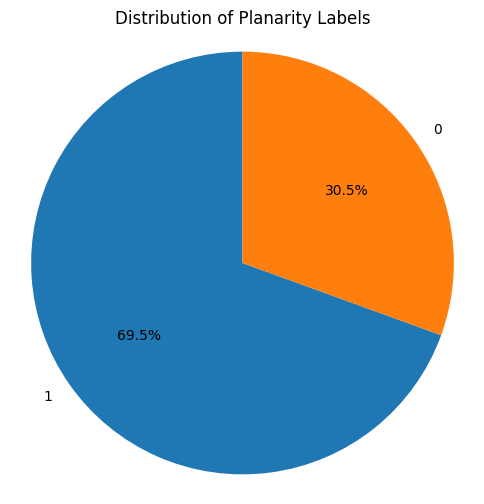

In [82]:
import matplotlib.pyplot as plt

# Count the occurrences of each label (0 and 1)
label_counts = {}
for label in y:
    label_counts[label] = label_counts.get(label, 0) + 1

# Extract labels and counts for the pie chart
labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Planarity Labels')
plt.show()

## 1.1 Train-Test split

In [83]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 1.2 Logistic regression

We can train Logistic Regression for that task. So far, nothing new.

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logloss_logreg = log_loss(y_test, logreg.predict_proba(X_test))
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

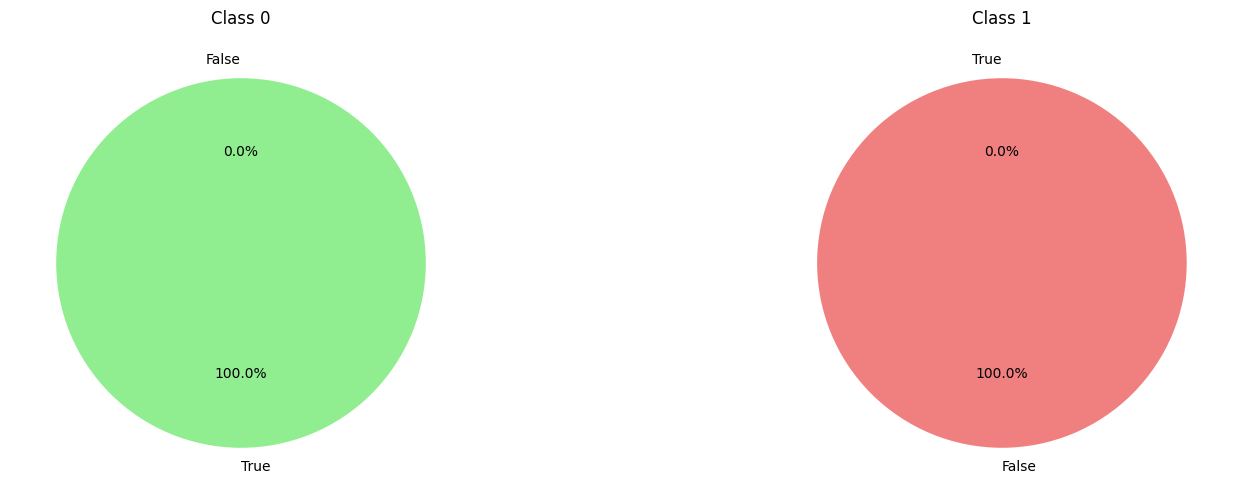

In [79]:
def plot_pie_charts(y_true, y_pred):
    labels = np.unique(y_true)

    fig, axes = plt.subplots(1, len(labels), figsize=(18, 6)) # Adjust figure size as needed

    for i, label in enumerate(labels):
        true_positives = np.sum([(y_true[j] == label) & (y_pred[j] == label) for j in range(len(y_true))])
        total_elements = np.sum([y_true[j] == label for j in range(len(y_true))])

        proportions = [true_positives, total_elements - true_positives]

        axes[i].pie(proportions, labels=['True', 'False'], autopct='%1.1f%%', startangle=90,
                    colors=['lightgreen', 'lightcoral'])
        axes[i].set_title(f"Class {label}")

    plt.show()

plot_pie_charts(y_test.values, y_pred_logreg)


For better results we need better models.

In [10]:
import pandas as pd
# Create a table
data = {'Model': ['Logistic Regression'],
        'LogLoss': [logloss_logreg],
        'Accuracy': [accuracy_logreg]}
results_df = pd.DataFrame(data)
results_df

,Model,LogLoss,Accuracy
0,Logistic Regression,0.615467,0.6945


Let's try regression with balanced weights

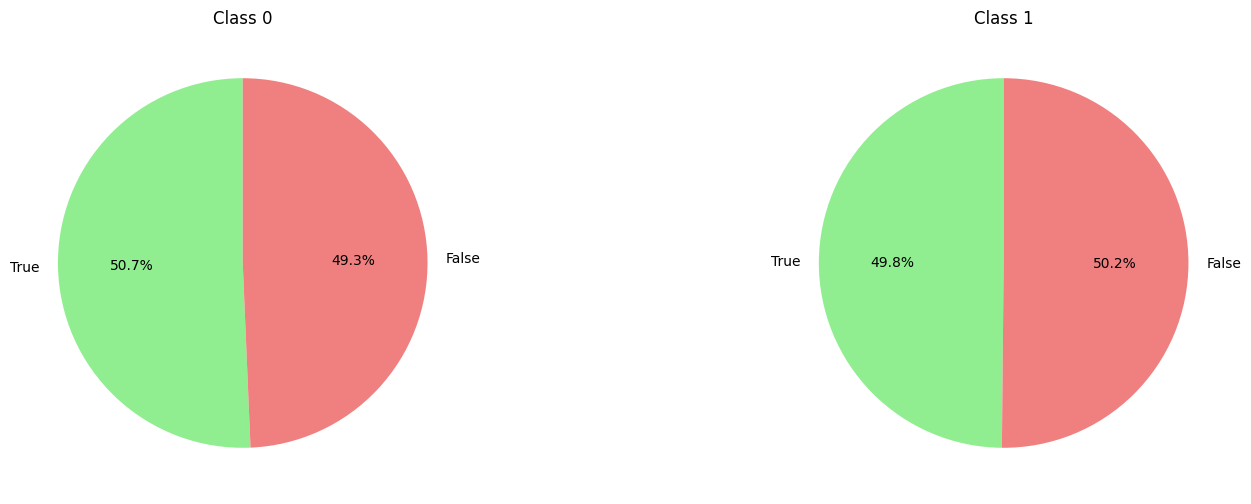

,Model,LogLoss,Accuracy
0,Logistic Regression,0.615467,0.6945
1,Balanced Logistic Regression,0.693183,0.5010


In [11]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logloss_logreg = log_loss(y_test, logreg.predict_proba(X_test))
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

plot_pie_charts(y_test.values, y_pred_logreg)

results_df.loc[len(results_df)] = [
    "Balanced Logistic Regression",
    logloss_logreg,
    accuracy_logreg
    ]
results_df

We now will try to implement Polynomial classification:

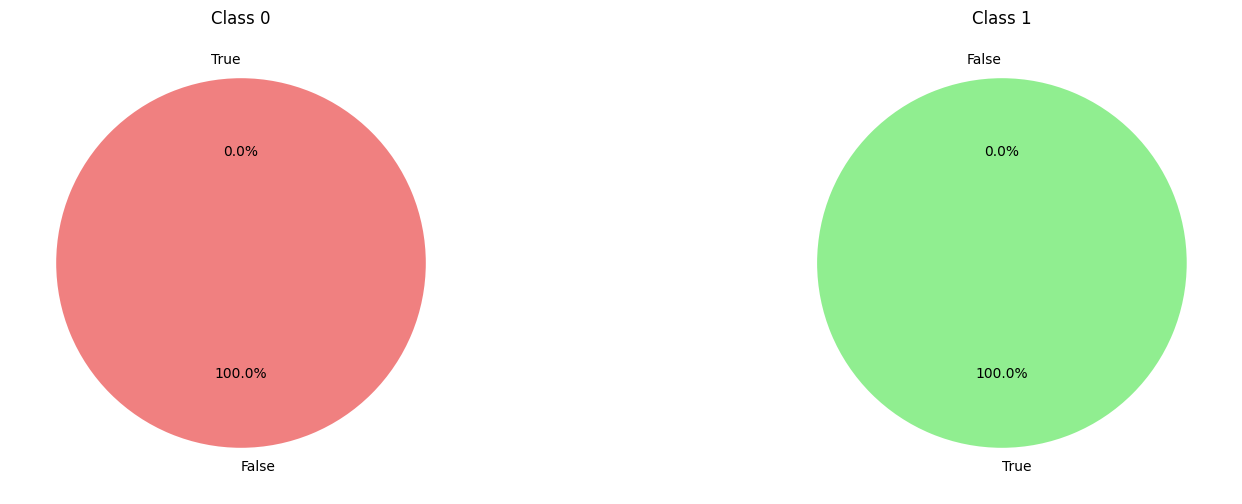

,Model,LogLoss,Accuracy
0,Logistic Regression,0.615467,0.6945
1,Balanced Logistic Regression,0.693183,0.5010
2,Poly Logistic Regression,0.613024,0.6945


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split


pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

logloss = log_loss(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

plot_pie_charts(y_test.values, y_pred)

results_df.loc[len(results_df)] = [
    "Poly Logistic Regression",
    logloss,
    accuracy
    ]
results_df

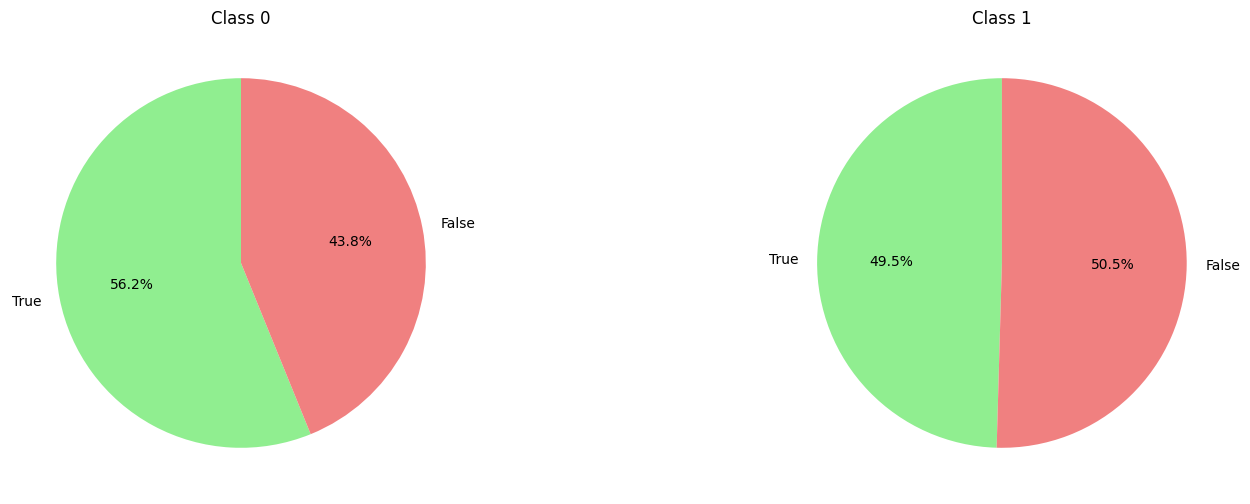

,Model,LogLoss,Accuracy
0,Logistic Regression,0.615467,0.69450
1,Balanced Logistic Regression,0.693183,0.50100
2,Poly Logistic Regression,0.613024,0.69450
3,Balanced Poly Logistic Regression,0.690083,0.51565


In [13]:

pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

logloss = log_loss(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

plot_pie_charts(y_test.values, y_pred)

results_df.loc[len(results_df)] = [
    "Balanced Poly Logistic Regression",
    logloss,
    accuracy
    ]
results_df

However, it fails to generalize the classification for points with coordinates in the range from -1000 to 1000.

In [14]:
df_l = generate_quadrilateral_dataset(100000, xy_range=(-1000,1000),random_state=random_state)
X_l = df_l.drop(columns=['label'])
y_l = df_l['label']

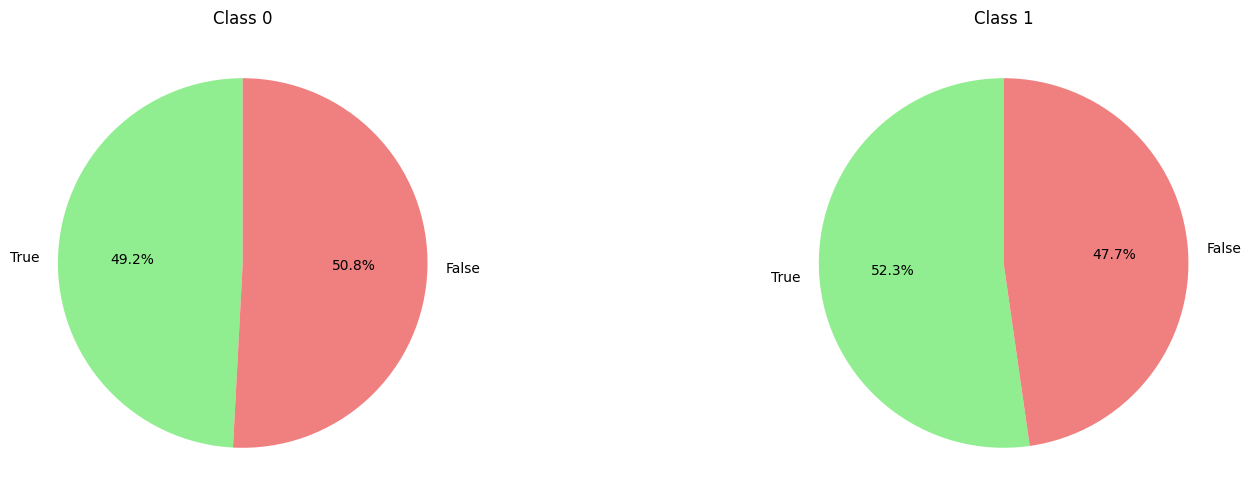

In [15]:
y_pred_l = pipeline.predict(X_l)
y_proba_l = pipeline.predict_proba(X_l)

logloss = log_loss(y_l, y_proba_l)
accuracy = accuracy_score(y_l, y_pred_l)

plot_pie_charts(y_l.values, y_pred_l)

# 2. Neural Networks

We'll now discuss **Feed-Forward Neural Networks** (MLPs) and their PyTorch interface.

Effective data representation is crucial in Machine Learning, as we saw with Linear and Logistic Regression. Neural networks automate feature engineering, eliminating the need for manual feature creation.

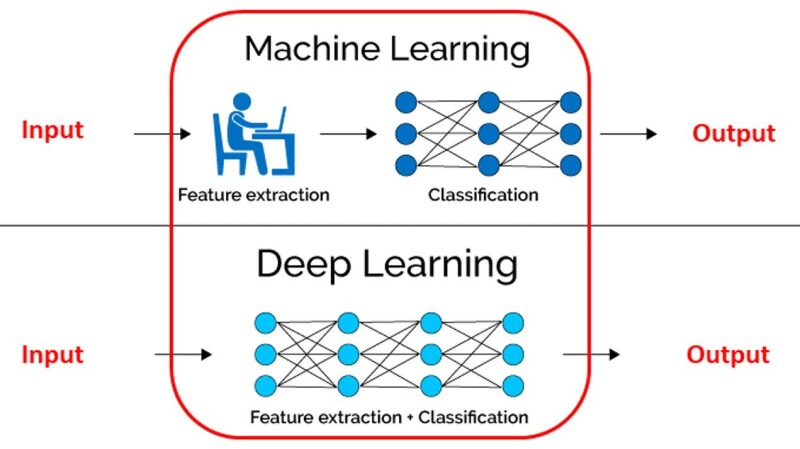

## 2.1 How to make a Neural Network?


>   **Neural networks** are computational graphs trained using gradient descent to adjust their weights.


**Example**: Logistic Regression can be understood as a composition of a linear transformation and the sigmoid function (see figure below)

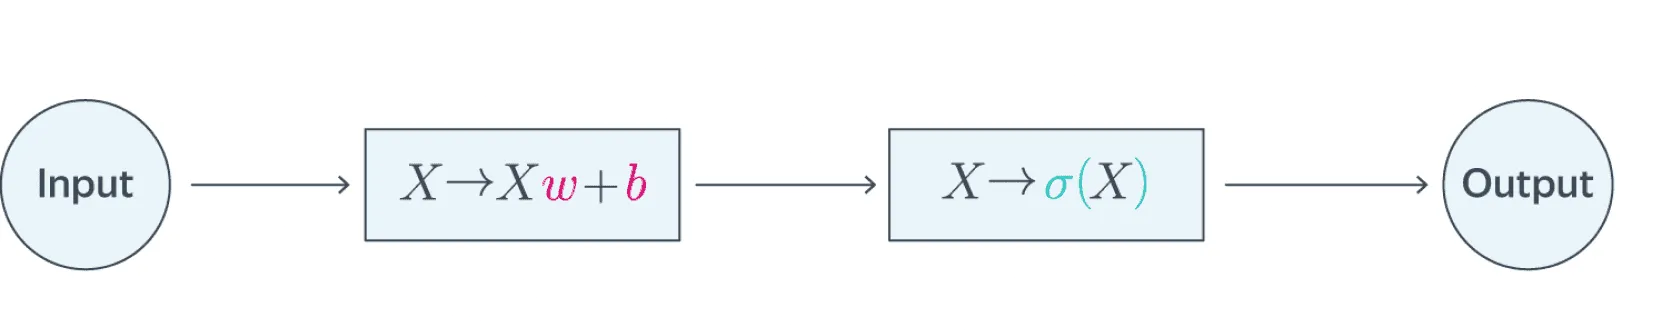

[PyTorch](https://pytorch.org/) provides a convenient interface for building computational graphs. We'll demonstrate this by implementing Logistic Regression. First, we import the necessary libraries:

In [16]:
import torch
import torch.nn as nn

Next, if our model is a sequence of maps $$\text{Input}  \xrightarrow{f_0}  \mathbb{R}^{n_1}  \xrightarrow{f_1} \mathbb{R}^{n_2}  \xrightarrow{f_2}  \dots \mathbb{R}^{n_{k-1}} \xrightarrow{f_{k-1}}  \mathbb{R}^{n_k}  \xrightarrow{f_k}  \text{Output},$$ then we use [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module and list all the functions.



In [17]:
input_size, output_size = 10, 1

LogReg1 = nn.Sequential(
    nn.Linear(input_size, output_size),
    nn.Sigmoid()
)

There are equivalent ways to express the same code:

In [18]:
# same as the above code
LogReg1b = nn.Sequential()
LogReg1b.add_module('fc1', nn.Linear(input_size, output_size))
LogReg1b.add_module('act', nn.Sigmoid())

In [19]:
from collections import OrderedDict

# Also same as the above code
LogReg1c = nn.Sequential(OrderedDict([
          ('fc', nn.Linear(input_size, output_size)),
          ('act', nn.Sigmoid()),
        ]))

You should check [torch.nn](https://pytorch.org/docs/stable/nn.html) for standard modules. For instance:

*   [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) Applies an affine linear transformation to the incoming data: $y=xA^T+b$.

*   [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) Applies the Sigmoid function element-wise $$\sigma(x)=\frac{1}{1+\exp(-x)}.​$$

Below we'll explore some other popular modules.

Need a function more intricate than what's readily available? No problem! PyTorch's nn.Module class allows you to [build custom modules](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html).

Need a more complex computational graph? No problem! Define a custom `nn.Module` as shown in the example below.



In [20]:
# Define your model
class LogReg(nn.Module):
    def __init__(self, input_size):
        super(LogReg, self).__init__() # initialize the class

        # Describe the necessary maps
        self.fc = nn.Linear(input_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        # Apply your maps
        out = self.fc(x)
        out = self.act(out)
        return out

input_size = 8
# Create an instance of your model
model_logreg = LogReg(input_size)

In [21]:
LogReg(5)

LogReg(
  (fc): Linear(in_features=5, out_features=1, bias=True)
  (act): Sigmoid()
)

## 2.2 PyTorch tensors

PyTorch neural networks require data to be represented as [PyTorch tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html). NumPy arrays can be readily converted to and from PyTorch tensors, and they share a similar interface.

In [22]:
# Create a tensor from a NumPy array
xx = torch.from_numpy(np.array([1, 2, 3, 4, 5, 6]))
print(xx)

# Basic operations
yy = xx.reshape(2, 3)
print(yy)

tensor([1, 2, 3, 4, 5, 6])
tensor([[1, 2, 3],
        [4, 5, 6]])


Tensor shape:

In [23]:
print(yy.shape)

torch.Size([2, 3])


We can novert back to Numpy array:

In [24]:
numpy_array = xx.numpy()
print(numpy_array)

[1 2 3 4 5 6]


### 2.2.1 Data types

Tensors can hold various data types (e.g., `float32`, `float64`, `int64`).

*   `float32` and `float64` are commonly used for real-valued numbers.
*   `int64` is suitable for integers.

Usually, in DL, double precision is not required and it adds an extra memory and performance overhead. Common practice is to use the 32-bit float type, or even the 16-bit float type, which is more than enough.

For more information see PyTorch documentation: https://pytorch.org/docs/main/tensor_attributes.html#torch.dtype

In [25]:
print(y.dtype)

# Tensor with all ones
z = torch.ones((2,3)) # type of desired tensor: dtype=torch.float32
print(z)
print(z.dtype) # float32 is the default type

yy = yy + z
print(yy) # int + float = float

print(yy.dtype)

int64
tensor([[1., 1., 1.],
        [1., 1., 1.]])
torch.float32
tensor([[2., 3., 4.],
        [5., 6., 7.]])
torch.float32


### 2.2.2 Inplace and Functional operators

There are two types of operation for tensors:

*   **Functional** operators, e.g. `w = y + z`.  Functional operators create a copy of the tensor with the performed modification, leaving the original tensor untouched.

*   **Inplace** operations, e.g. `y += z`. (Inplace operations often have an underscore appended to their name, e.g. `.zero_`.) Inplace operations modify the existing tensor. They are more time and memory efficient, but may lead to hidden bugs.



In [26]:
# Create a tensor from a NumPy array
xx = torch.zeros(1, 4)
print(xx)
print()
yy = xx.reshape(2, 2)

# Inplace operators modify the tensor
z1 = torch.ones((2,2))
yy += z1
print(yy)
print(xx) # x has also change
print()

# Functional operators create new tensors
z2 =  torch.ones((2,2))
yy = yy + z2
print(yy)
print(xx) # x has not changed

tensor([[0., 0., 0., 0.]])

tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1., 1., 1.]])

tensor([[2., 2.],
        [2., 2.]])
tensor([[1., 1., 1., 1.]])


### 2.2.3 Item of a $1\times 1$ tensor

For $1\times 1$ Pytorch tensors we can access their value with `item()` command:

In [27]:
# Create a 1x1 tensor
tensor = torch.tensor([[10]])

# Access the single value using indexing
value = tensor[0, 0]

# Print the value
print(value)  # Output: tensor(10)

# Get the Python scalar value using .item()
scalar_value = value.item()
print(scalar_value)  # Output: 10

tensor(10)
10


### 2.2.4 Useful  matrix operations

In [28]:
# Example of torch.stack
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.stack([a, b])
print("Stack:\n", c)

# Example of torch.transpose
xx = torch.randn(2, 3)
print("Original tensor:\n", xx)
yy = torch.transpose(xx, 0, 1)  # Transpose dimensions 0 and 1
print("Transposed tensor:\n", yy)

# Example of torch.cat
t1 = torch.tensor([[1, 2], [3, 4]])
t2 = torch.tensor([[5, 6], [7, 8]])
t3 = torch.cat((t1, t2), dim=0) # Concatenate along dimension 0 (rows)
print("Concatenated tensor along dim 0:\n",t3)
t4 = torch.cat((t1, t2), dim=1) # Concatenate along dimension 1 (columns)
print("Concatenated tensor along dim 1:\n",t4)

Stack:
 tensor([[1, 2, 3],
        [4, 5, 6]])
Original tensor:
 tensor([[ 0.5649,  0.4349, -1.4226],
        [ 1.3075, -0.5353, -0.2244]])
Transposed tensor:
 tensor([[ 0.5649,  1.3075],
        [ 0.4349, -0.5353],
        [-1.4226, -0.2244]])
Concatenated tensor along dim 0:
 tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])
Concatenated tensor along dim 1:
 tensor([[1, 2, 5, 6],
        [3, 4, 7, 8]])


## 2.3 Dataloaders

### 2.3.1 Tensor Batches

Neural networks function as mappings that can process both individual PyTorch tensors and **batches of tensors**. During training, neural networks typically operate on batches of data, processing $B$ samples simultaneously, where $B$ is the batch size.

A batch is represented as a multi-dimensional tensor, with the first dimension denoting the batch size. For example, if the input to a network is a tensor of size $(D)$, the corresponding batch would have dimensions $(B,D)$. When processing a batch, the network applies its function independently to each individual tensor within the batch.

In [29]:
input_size, output_size = 10, 1
batch_size = 5

# Create the neural network
model_logreg = nn.Sequential(
    nn.Linear(input_size, output_size),
    nn.Sigmoid()
)

# Create a sample input tensor
input_tensor = torch.randn(batch_size, input_size)  # Example: batch size of 5 with 10 features

# Apply the neural network
output_tensor = model_logreg(input_tensor)

# Print the output
output_tensor

tensor([[0.5183],
        [0.3535],
        [0.6811],
        [0.7432],
        [0.6685]], grad_fn=<SigmoidBackward0>)

### 2.3.2 Dataloaders

To load tensors in batches, create an object of the **Dataloader** class. Instruction https://pytorch.org/vision/stable/datasets.html

We specify:

*   *Dataset* that contains the data
*   *Batch_size* = how many images to take at a time
*   *Shuffle* = do we need to shuffle the data
*   *Num_workers* =  how many parallel processes to create (usually the number of cores in the processor)


In [30]:
# from torch.utils.data import Dataset, DataLoader

# # Sample data (replace with your actual data)
# X = torch.randn(100, 10)  # 100 samples, 10 features
# y = torch.randint(0, 2, (100,))  # 100 binary labels

# class MyDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# BATCH_SIZE = 32

# # Create dataset and dataloader
# dataset = MyDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# # Iterate over the dataloader
# for batch_X, batch_y in dataloader:
#     print("Batch X shape:", batch_X.shape)
#     print("Batch y shape:", batch_y.shape)
#     # Process your batch here (e.g., feed it to the model)
#     break # just for demonstration

# 3. Feedforward neural network (FFNN)


## 3.1 Activation functions

Let's attempt to construct a neural network that we have not already seen.

*   <font color='blue'> **Question:**</font> Should we apply two linear maps sequentially?


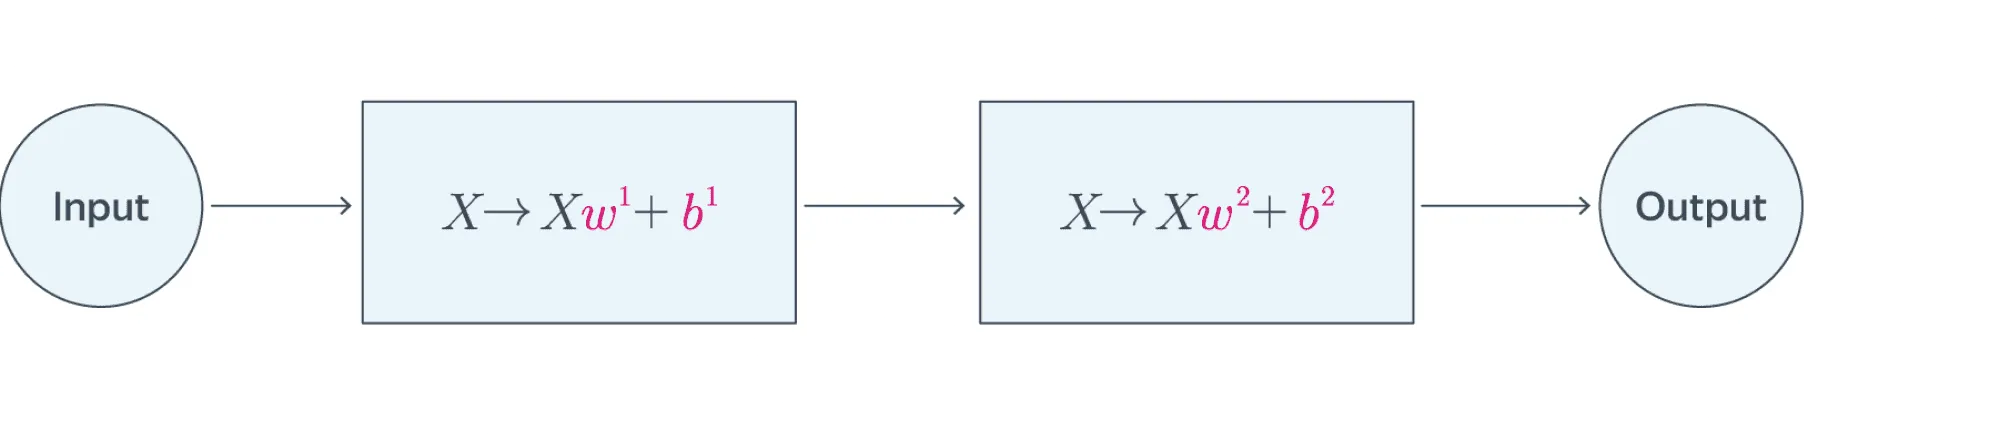

 In general, no, because compisition of linear maps is also a linear map: $$\left(Xw^1 + b^1\right) w^2 + b^2 = X w^1 w^2 + \left( b^1 w^2 + b^2\right).$$

A basic neural network is composed of alternating linear transformations and non-linear activation functions. Common activation functions include:








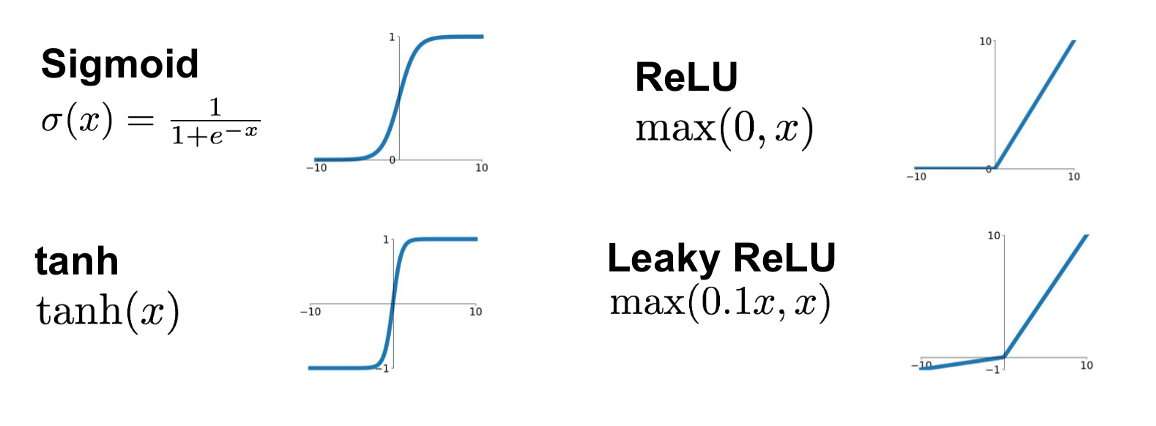

As a general guideline:


* Employ **ReLU** or **LeakyReLU** activation functions *between linear layers*.
* Utilize **Sigmoid** or **Tanh** activation functions *in the output layer* to constrain outputs to the range $(0, 1)$ or $(-1, 1)$, respectively.

Briefly, Sigmoid and Tanh functions can be computationally more expensive and have "worse gradients".

In practice, it is <ins>recommended to prioritize the activation functions specifically mentioned in the articles</ins>.

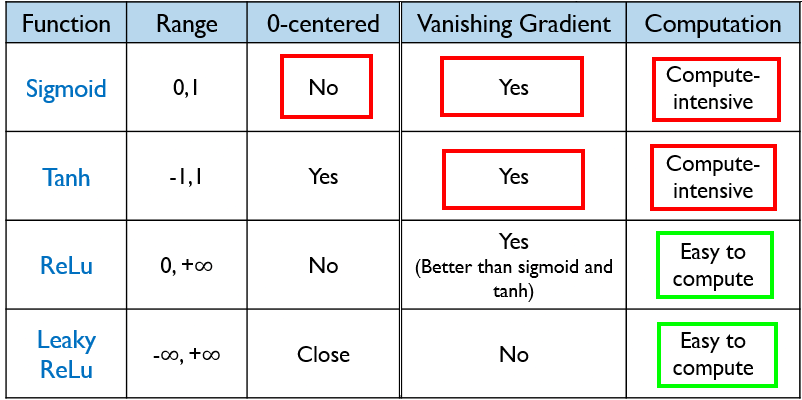

Activation functions are implemented within the `torch.nn` module in PyTorch. Refer to the official documentation for more details: https://pytorch.org/docs/stable/nn.html

In [31]:
# Example of activation function
m = nn.LeakyReLU(0.1)
input = torch.randn(2)
output = m(input)
output

tensor([-0.1497, -0.0495])

## 3.2 Layers

A simple neural network can be visualized as a sequence of **layers**, as illustrated in the diagram below. Such neural networks that take the input, feed it through several layers one after the other, and then finally gives the output, are called **feed-forward neural networks (FFNN)**.

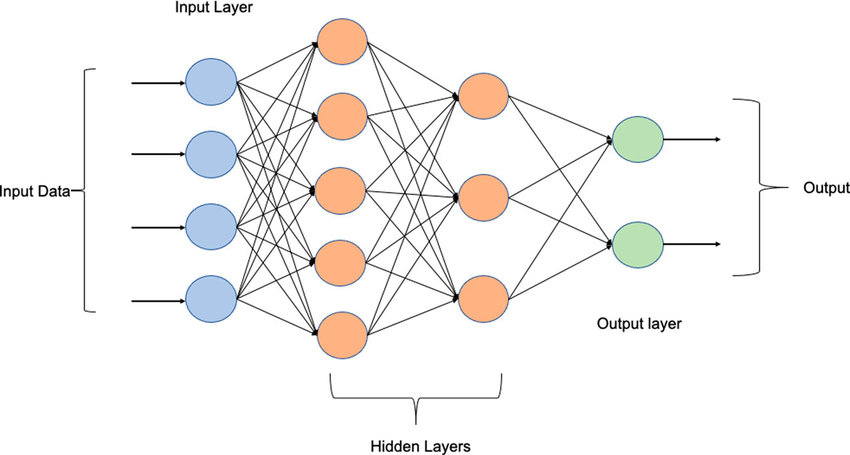

It is important to note that terminology related to neural networks can vary across different sources. We will use the following definitions:

1. **Dense Layer** =  **Linear Layer** = linear transformation over the input data $f(x)=Wx+b$.

2.  **Activation function**: nonlinear transformation element-by-element applied to the input data (e.g. `ReLU`).

3.  **Hidden layer** = additional layers between the input layer and the output layer.

Note that the term *'layer'* can have multiple meanings in the context of neural networks. It is typical to say smth like:

> This FFNN (Feedforward Neural Network) has two hidden layers with ReLU (or LeakyReLU) activations between them, followed by an output layer with a Sigmoid (or Tanh) activation.

In [32]:
from collections import OrderedDict

input_size, hidden_size1, hidden_size2, output_size = 4, 5, 3, 2

model = nn.Sequential(OrderedDict([
            ('hidden_linear1', nn.Linear(input_size, hidden_size1)),
            ('hidden_activation1', nn.ReLU()), # Or nn.LeakyReLU()
            ('hidden_linear2', nn.Linear(hidden_size1, hidden_size2)),
            ('hidden_activation2', nn.ReLU()), # Or nn.LeakyReLU()
            ('output_linear', nn.Linear(hidden_size2, output_size)),
            ('output_activation', nn.Sigmoid()) # Or nn.Tanh()
        ]))

model

Sequential(
  (hidden_linear1): Linear(in_features=4, out_features=5, bias=True)
  (hidden_activation1): ReLU()
  (hidden_linear2): Linear(in_features=5, out_features=3, bias=True)
  (hidden_activation2): ReLU()
  (output_linear): Linear(in_features=3, out_features=2, bias=True)
  (output_activation): Sigmoid()
)

Playground to play with simple Neural Networks: https://playground.tensorflow.org

## 3.3 Torch Summary


Large models can quickly become difficult to understand and maintain.


[PyTorch's summary](https://pypi.org/project/torch-summary/) is a useful function for understanding a model's structure. It clearly presents layer configurations, the number of parameters, and the output tensor shapes at each stage of the network.

Note that the tensor sizes are typically represented as $(-1, X_1, \dots, X_k)$, where $-1$ signifies an arbitrary **batch size**.

In [33]:
from torchsummary import summary

summary(model, (input_size,))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

# 4. How to train your model

Neural Networks are trained following the standard ML scheme. Now, let's explore a practical code example.

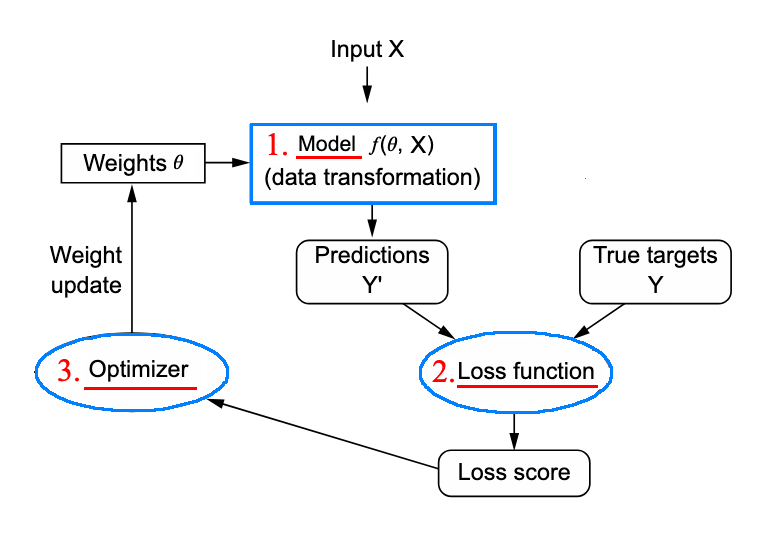

## 4.1 Define a Neural Network

Load basic torch libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


Let's start with a dense network for our baseline:


In [48]:
import torch
import torch.nn as nn

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

# Example usage
input_size = 8  # Replace with your input size
hidden_size = 64  # Replace with your desired hidden size
output_size = 1  # Replace with your output size

# Create an instance of the MLP
model = MLP(input_size, hidden_size, output_size)

## 4.2 Datasets

Let's prepare our data. First, train-test split.

In [49]:
from sklearn.model_selection import train_test_split

df = generate_quadrilateral_dataset(100000, random_state=random_state)
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Next, we make Dataloaders.

In [50]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32

# Create dataset and dataloader
train_dataset = MyDataset(X_train.values, y_train.values)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = MyDataset(X_test.values, y_test.values)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Don't shuffle
print(len(train_dataloader), len(test_dataloader))
print(len(train_dataloader)*BATCH_SIZE, len(test_dataloader)*BATCH_SIZE)

2500 625
80000 20000


### 4.3 Loss function

Loss functions reside in the `nn` package (see [https://pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)). The most commonly used standard loss functions are:


1.  [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss): The mean square error between arguments, which is the standard loss for **regression problems**. $$\operatorname{MSE}(\hat{y}, y) = \frac{1}{N} \sum_{i=1}^N \left(\hat{y}_i - y_i \right)^2.$$
2.  [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss) and [nn.BCEWithLogits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss). The first loss is the binary cross-entropy loss, which we already know: $$\operatorname{BCELoss}(p, y) = -\frac{1}{n} \sum_{i=1}^n w_i \left[y_i \log p_i + (1-y_i) \log(1-p_i)\right],$$ where $w_i$ are the weights. The second one combines a Sigmoid layer and the BCELoss in one single class.


*  The first version expects a <ins>single probability value</ins> (usually it's the output of the Sigmoid layer).
*   The second version assumes <ins>raw scores as input and applies Sigmoid itself</ins>. *The second way is usually more numerically stable and efficient.*

These losses (as their names suggest) are frequently used in **binary classification problems**.

3.  [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) and [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss): Famous “maximum likelihood” criteria that are used in **multi-class classification problems**.

*  The first version expects raw scores for each class and applies internally.

* The second expects to have log probabilities as the input.



In [51]:
# Define loss function
criterion = nn.BCELoss()

For alternative metrics or loss functions, consult the PyTorch Metric Collection at  https://pytorch.org/torcheval/main/torcheval.metrics.html. If the desired metric is not available, you can define it yourself as a custom function. *It's generally advisable to leverage existing implementations whenever possible.*

## 4.4 Backpropagation

Neural network transformations involve parameters (**weights**) that must be learned during training. For example, the dense layer represented by $$f(x)=Wx+b,$$ the weights are the weight matrix $W$ and the bias vector $b$.

> Neural network weights are determined through <font color='blue'>**gradient descent optimization**</font>.

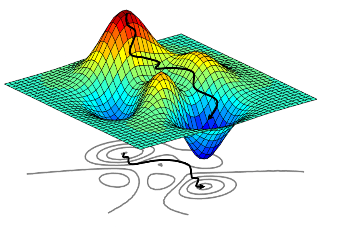

### 4.4.1 Simple example

Consider a simple example: the composition of two linear maps, $$L(x) = F_2(F_1 (x)) = F_2 (W_1 x) = W_2 W_1 x.$$ where $F_i = W_i x$ are linear maps without bias. To optimize this system using gradient descent, we require the gradients: $$\frac{\partial L}{\partial W_1} = ?  \qquad \frac{\partial L}{\partial W_2} = ?$$ The gradient with respect to $W_2$ is straightforward: $$\frac{\partial L}{\partial W_2} = \frac{\partial F_2}{\partial W_2}.$$ For the gradient with respect to $W_1$, let $y_1 = F_1(x)$. Applying the chain rule yields $$\frac{\partial L(x)}{\partial y_1} =\frac{\partial F_2(F_1(x))}{\partial y_1} =\frac{\partial F_2(y_1)}{\partial y_1} \frac{\partial F_1(x)}{\partial W_2}. $$ In essence, *if we can compute the derivatives of each function $F_i$ with respect to both its input $x_i$ and its weights $W_i$, we can effectively determine all necessary gradients for the optimization process*. This principle extends to any computational graph within a neural network.

In Deep Learning (DL) **backpropagation** is a fancy word for "chain rule". It's common to say that "The network is trained using backpropagation".

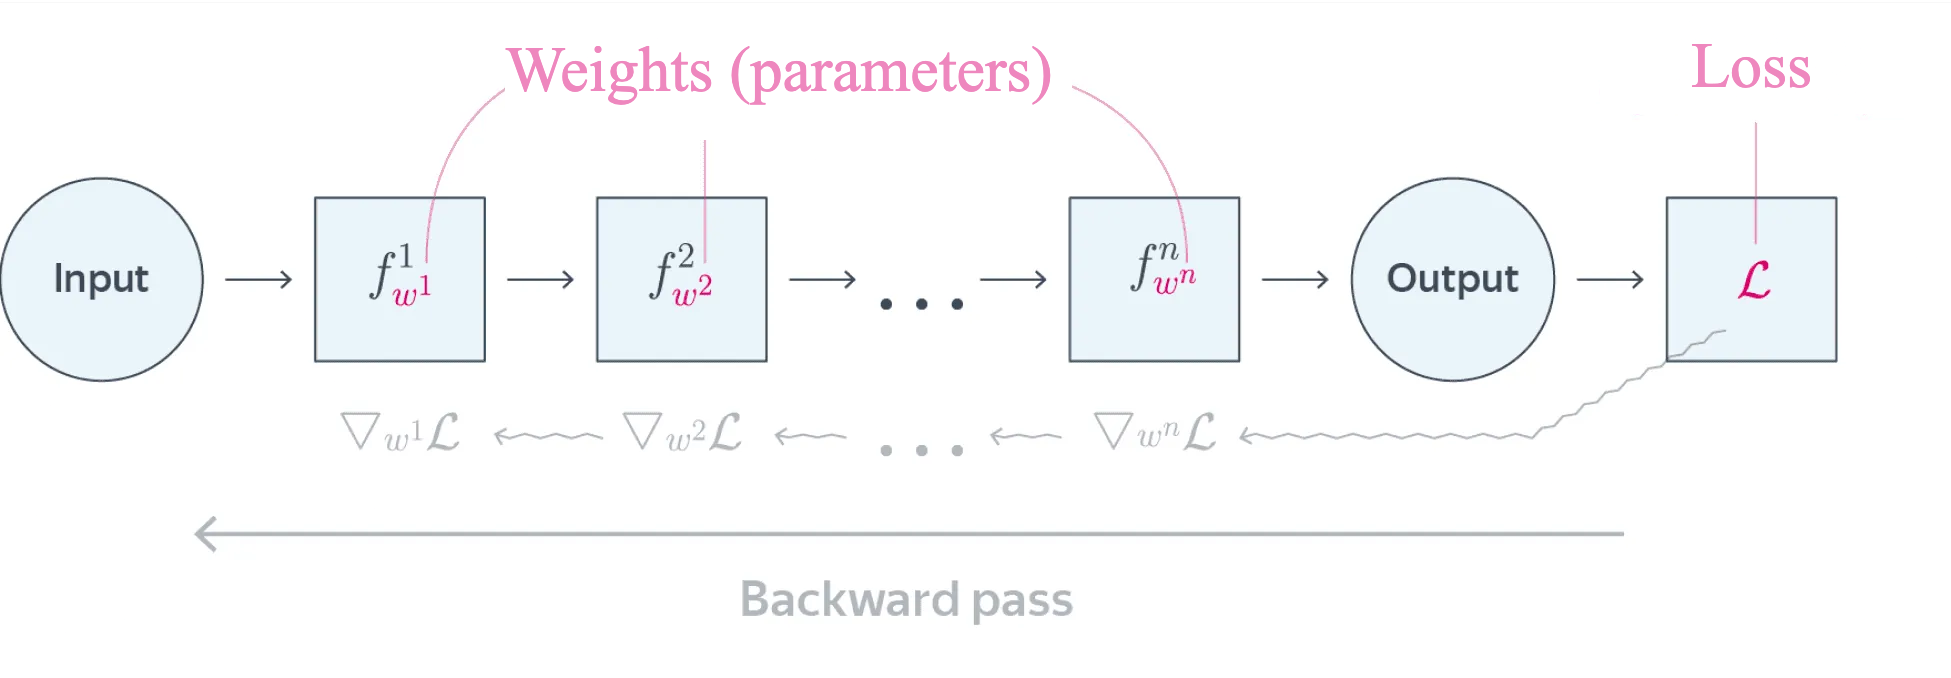

### 4.4.2 Matrix derivatives

Backpropagation primarily presents a practical challenge rather than a theoretical one. Calculating matrix derivatives can be cumbersome, but often, the resulting expressions can be determined by analyzing the dimensions of the matrices.

<font color='blue'>**Question:**</font> find the derivative below.


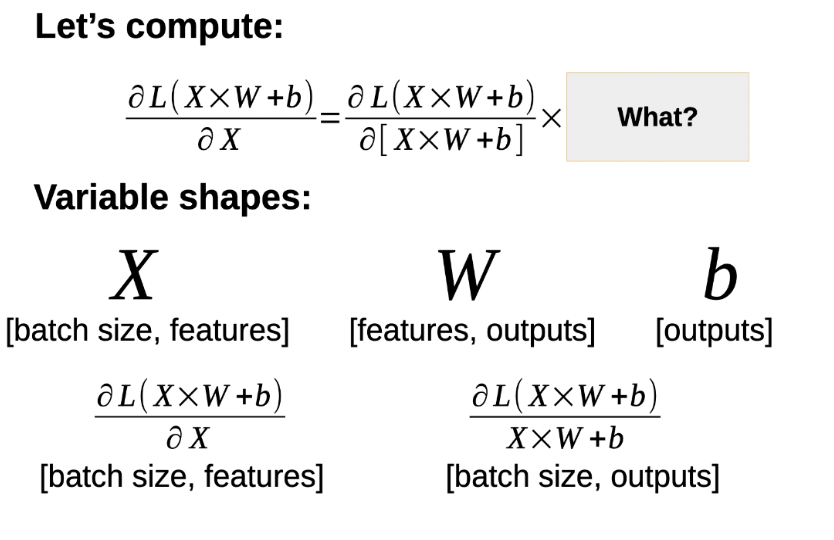

### 4.4.3 Example of Backprop

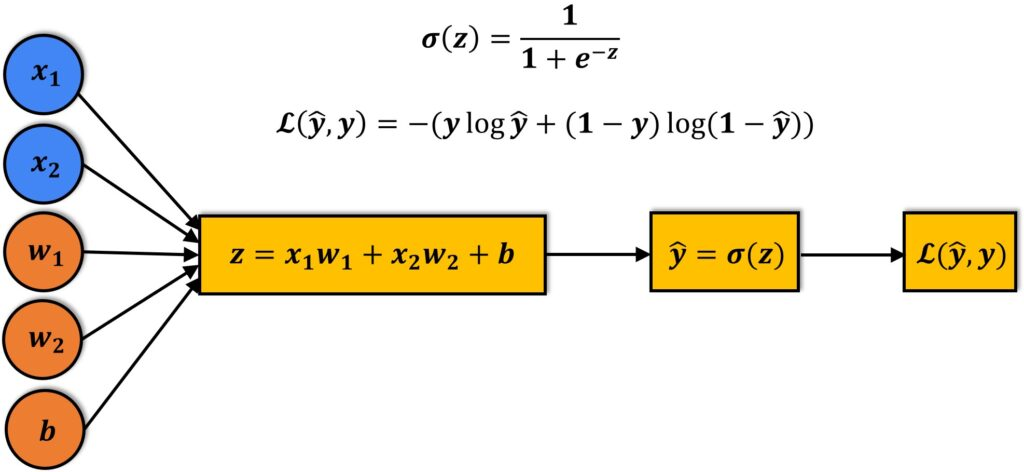

Consider a simple neural network (NN) defined by: $$\hat{y} = \sigma(XW + b),$$ where σ is the sigmoid activation function. The network is trained using the LogLoss function: $$\mathcal{L} =\mathcal{L}(y, \hat{y}) = y \log(\hat{y}) + (1-y) \log(1- \hat{y}).$$ Denote $Z = XW + b$. We will now derive the gradients for this model step-by-step.

1.   The gradient of the loss function $\mathcal{L}$  with respect to the predicted output $\hat{y}$ is $$\color{blue} {\nabla_{\hat{y}}\mathcal{L} = \frac{y- \hat{y}}{\hat{y}(1 - \hat{y})}}.$$
2.   Next, we apply the chain rule:  $$\nabla_{Z} \mathcal{L} = \sigma'(Z) \odot \nabla_{\hat{y}}\mathcal{L}.$$ Since $\sigma'(Z) = \sigma(Z) \left( 1 - \sigma(Z)\right)$, and substituting the previously derived expression for $\nabla_{\hat{y}}\mathcal{L}$ we get: $$\color{blue} { \nabla_{Z} \mathcal{L}} = \sigma(Z) \left( 1 - \sigma(Z)\right)  \odot \frac{y - \sigma(Z)}{\sigma(Z)\left( 1 - \sigma(Z)\right)} = \color{blue} {y - \sigma(Z)}.$$

3. The derivate w.r.t. $W$ is $$\color{red}{ \nabla_{W} \mathcal{L}} = X^T \nabla_{Z} \mathcal{L} = \color{red} { X^T \left( y - \sigma(WX+b)\right)}.$$

4. The derivate w.r.t. $b$ is $$\color{red} { \nabla_{b} \mathcal{L}} = I_p \nabla_{Z} \mathcal{L} = \color{red} {  y - \sigma(WX+b)}.$$

This calculation demonstrates a straightforward procedure. However, in more complex scenarios, the calculations follow a similar principle but become considerably more cumbersome.


### 4.4.4 Pytorch tensor gradients


Good news! <font color='blue'> PyTorch handles the complex task of gradient calculation automatically</font>. Hence, you won't need to concern yourself with such calculations.

Every tensor has the following attributes related to gradients:

*   `grad `: A property that holds a tensor of the same shape containing computed gradients.
*   `is _leaf`:  Equals `True` if this tensor was constructed by the user and `False` if the object is a result of function transformation (in other words, has a parent in the computation graph).
*   `requires_grad`: Equals `True` if this tensor requires gradients to be calculated.

By default, the constructor has `requires_grad = False`, so if you want gradients to be calculated for your tensor, then you need to explicitly say so.

Let's consider a simple example:

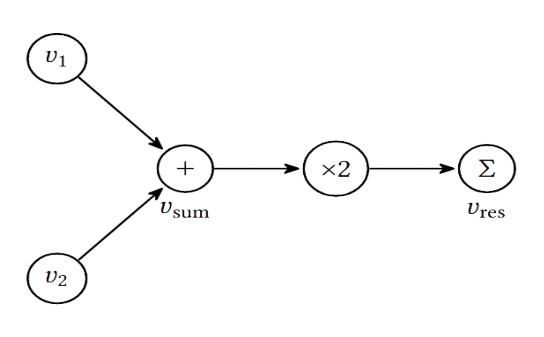

In [52]:
v1 = torch.tensor([1.0, 1.0], requires_grad=True)
v2 = torch.tensor([2.0, 2.0])

v_sum = v1 + v2
v_res = (v_sum*2).sum()
v_res

tensor(12., grad_fn=<SumBackward0>)

Now, let’s tell PyTorch to calculate the gradients of our graph:

In [53]:
v_res.backward()

The vertex v1 is a leaf and we can find its gradients:

In [54]:
print(v1.is_leaf, v1.requires_grad)
v1.grad

True True


tensor([2., 2.])

The vertex v2 is a leaf but we do not compute the gradients:

In [55]:
print(v2.is_leaf, v2.requires_grad)
v2.grad

True False


If we try calling gradient for the non-leaf vertex $v_{sum}$ we get an interesting meassage:

In [56]:
print(v_sum.is_leaf, v_sum.requires_grad)
v_sum.grad

False True


<ipython-input-56-395e0fd4a5a8>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  v_sum.grad


As we can see:

1.   The property `requires_grad` is sort of “sticky”: if one of the variables involved in computations has it set to `True`, all subsequent nodes also have it.
2.   For memory efficiency, gradients are stored **only for leaf nodes** with `requires_grad=True`. If you want to keep gradients in the non-leaf nodes, you need to call their `retain_grad()` method, which tells PyTorch to keep the gradients for non-leaf node.

  

## 4.5 Optimizer

Calculating the full gradient, $$\nabla_{\theta} L = \sum_{i=1}^N \nabla_{\theta} L(\hat{y}_i, y_i)$$  can be computationally prohibitive for large datasets. To address this, various optimization techniques are used. Optimizing neural networks is a complex and active area of research. We only briefly touch it. PyTorch provides a variety of effective optimizers in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package.


*   We have previously discussed **Stochastic Gradient Descent** (SGD), a fundamental optimization algorithm: $$\theta_{t+1} = \theta_t - \operatorname{lr} \cdot \nabla_{\theta} L( \hat{y}_i, y_i).$$ For more details, see https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD



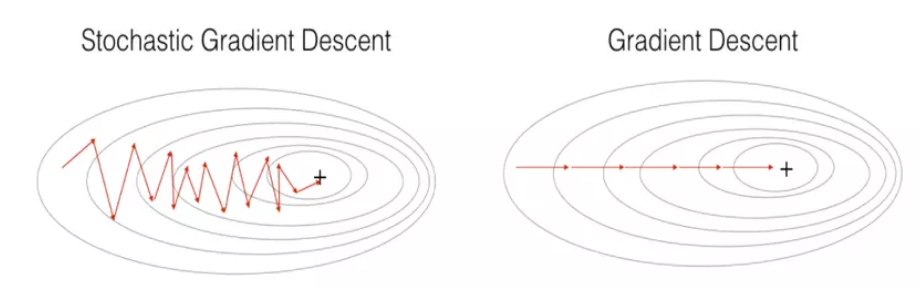


*   **Adam** is a widely-used and highly regarded optimizer. https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam


### 4.5.1 Adam optimizer

<font color='red'>These section about Adam optimizer is optional and may be skipped.</font>


Roughly speaking, Adam combined two following two ideas:


1.  **Momentum** addresses the issue of noisy gradients. The gradient $\nabla f(\theta_t)$ can exhibit significant fluctuations. By incorporating momentum, we effectively *``smooth'' the update direction*, potentially accelerating convergence towards the optimal solution.

In practice, we do smth like this:


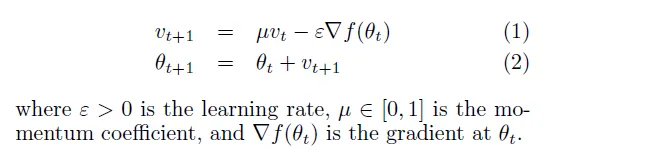


2. **Adaptive learning rates** such as Adagrad (Duchi et al., 2011) [https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf], *adjust the learning rate* for each parameter individually based on the history of gradients. Intuitively:
*   parameters with larger accumulated gradients receive smaller updates,
*   parameters with smaller accumulated gradients receive larger updates.



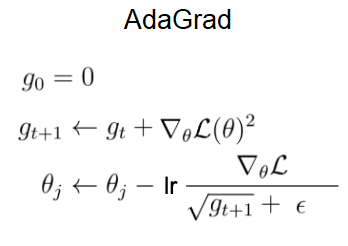



**Adam** (https://arxiv.org/abs/1412.6980) combines the benefits of momentum and adaptive learning rates. It utilizes momentum (represented by $m_t$) to guide the optimization in a more consistent direction and incorporates adaptive learning rates (represented by $v_{t}$) to adjust the step size for each parameter. $$m_{t+1} = \beta_1 m_{t}  + (1-\beta_1) \nabla f(\theta_t), \quad \text{(1st momentum)} \\ v_{t+1} = \beta_2 v_{t}  + (1-\beta_2) \left( \nabla f(\theta_t)\right)^2, \quad \text{(2nd momentum)} \\ \hat{m}_{t+1} = \frac{m_{t+1}}{1 - \beta_1^t}, \quad \hat{v}_{t+1} = \frac{v_{t+1}}{1 - \beta_2^t}, \quad \text{(bias-correction)}  \\ \theta_{t+1} = \theta_t - \operatorname{lr} \frac{\hat{m}_{t+1}}{\sqrt{\hat{v}_{t+1}} + \varepsilon} \quad \text{(update parameters)}.$$ <font color='red'> These formulas are provided for completeness but are not essential for understanding the core concepts. You may safely skip them.</font>

Theoretically, there are scenarios where Adam may not converge (see e.g.
https://arxiv.org/pdf/1904.09237). However, in practice, Adam consistently demonstrates strong performance across a wide range of tasks. This highlights the empirical nature of machine learning, where experimentation and real-world results often defy theoretical expectations.


### 4.5.2 Optimizer in practice

Fortunately, PyTorch provides a user-friendly interface for optimizers, eliminating the need to manually implement the underlying mathematical formulas.

In [57]:
# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

<int>Experiment with the learning rate</int>. Try values like $0.1$, $0.01$, and $0.001$ to find the best performance. Some people, try `lr = 3e-4` as suggested in the following famous tweet of Andrey Karpathy)

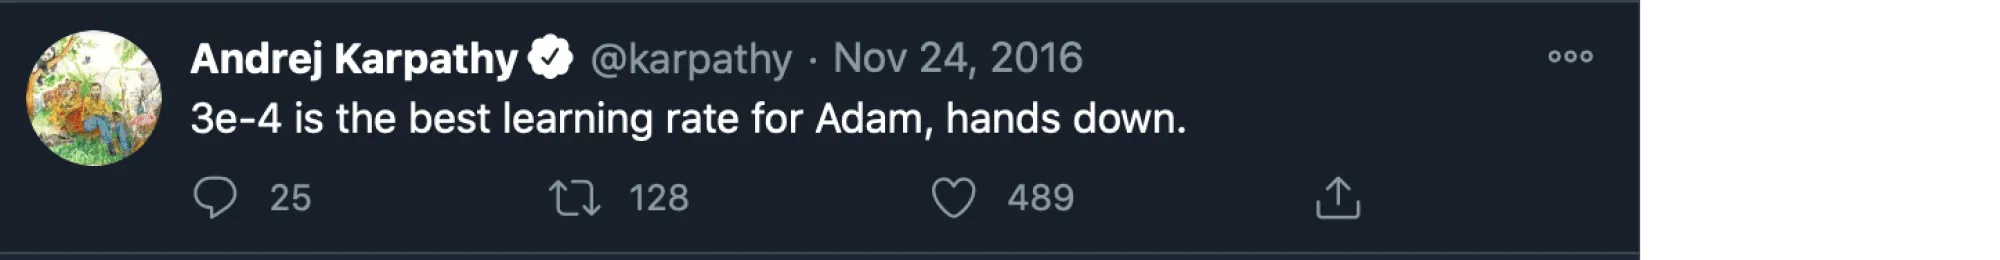

Unlike Logistic Regression, the loss function for most neural networks is non-convex. This means the loss landscape can be complex, with numerous local minima. In fact, visualizations of the loss surface (see
https://arxiv.org/pdf/1712.09913) often reveal quite challenging landscapes.

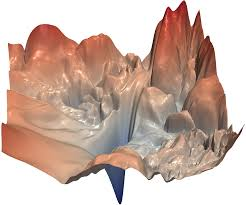

As a result, optimization algorithms can easily become trapped in local minima. Hence, experiments with learning rate are important.

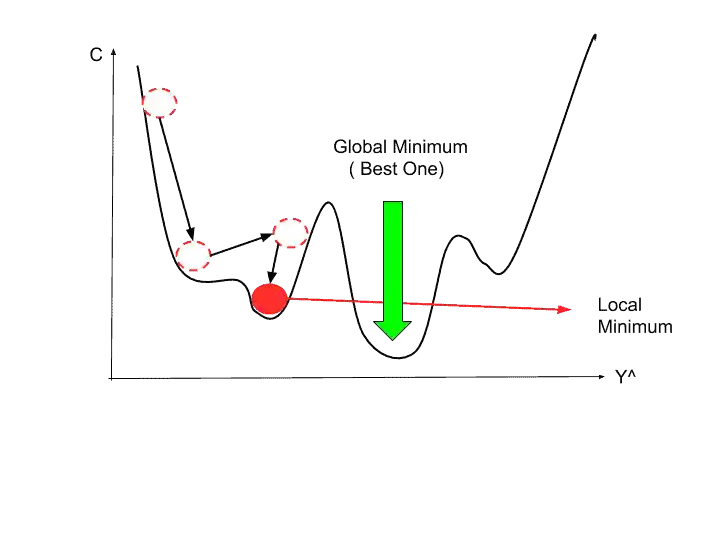

## 5 Training loop

Let's examine the basic training cycle for a neural network. Recall that we iterate over the entire dataset multiple times (**epochs**). Due to memory constraints, the data is divided into smaller **batches**.

The training loop consists of the following steps:

*   **Forward Pass**: The input data is fed into the network and the loss function is calculated.
*   **Backward Pass (Backpropagation)**: PyTorch automatically calculates the gradients of the loss with respect to all model parameters.
*   **Optimizer Step**: The optimizer (e.g., SGD, Adam) uses the computed gradients to update the model's parameters, aiming to minimize the loss.
*  **Gradient Clearing**:  Finally, the accumulated gradients are cleared to prepare for the next iteration. This is typically done by calling `optimizer.zero_grad()`.

In [63]:
num_epochs = 20 # total amount of full passes over training data
batch_size = 64  # number of samples processed in one iteration

train_loss = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    model.train(True) # more on that later
    epoch_train_loss = 0
    for X_batch, y_batch in train_dataloader:
        # train on batch
        X_batch = X_batch.type(torch.float32) # cast to float32
        y_batch = y_batch.float().reshape(-1, 1)

        # Calculate loss
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        # Backward and optimize
        loss.backward() # Calculate gradients
        opt.step() # Update parameters
        opt.zero_grad() # Zero all gradients

        epoch_train_loss += loss.item()
    train_loss.append(epoch_train_loss / len(train_dataloader))
    # We can print the results for this epoch:
    print("  training loss: \t{:.6f}".format(
        epoch_train_loss / len(train_dataloader)))

  training loss: 	0.339367
  training loss: 	0.336350
  training loss: 	0.333481
  training loss: 	0.331704
  training loss: 	0.329329
  training loss: 	0.326116
  training loss: 	0.324653
  training loss: 	0.323965
  training loss: 	0.321298
  training loss: 	0.318719
  training loss: 	0.317143
  training loss: 	0.315438
  training loss: 	0.314035
  training loss: 	0.311007
  training loss: 	0.311034
  training loss: 	0.309957
  training loss: 	0.306958
  training loss: 	0.305989
  training loss: 	0.305480
  training loss: 	0.303460


Ideally, the training loss should decrease over time.

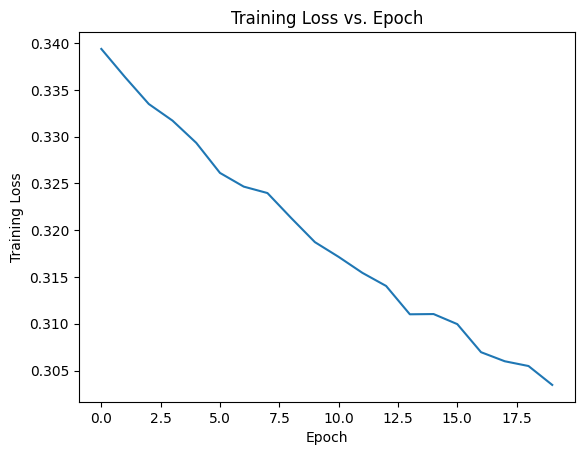

In [64]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

plt.title('Training Loss vs. Epoch')
plt.show()

During **inference** (i.e., on test data), gradient calculations are unnecessary. To optimize performance, we can disable gradient computation by setting `with torch.no_grad()`:

In [65]:
y_true = []
y_pred = []
y_pred_probs = []

model.eval()  # Set the model to evaluation mode (more on that later)
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.type(torch.float32)
        y_batch = y_batch.float().reshape(-1, 1)

        predictions = model(X_batch)
        y_pred_probs.extend(predictions.numpy())
        y_true.extend(y_batch.cpu().numpy().flatten())

logloss = log_loss(y_true, y_pred_probs)
y_pred = (np.array(y_pred_probs) > 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)
print(f"Test LogLoss: {logloss}")
print(f"Test Accuracy: {accuracy}")

Test LogLoss: 0.33362779638898876
Test Accuracy: 0.8511


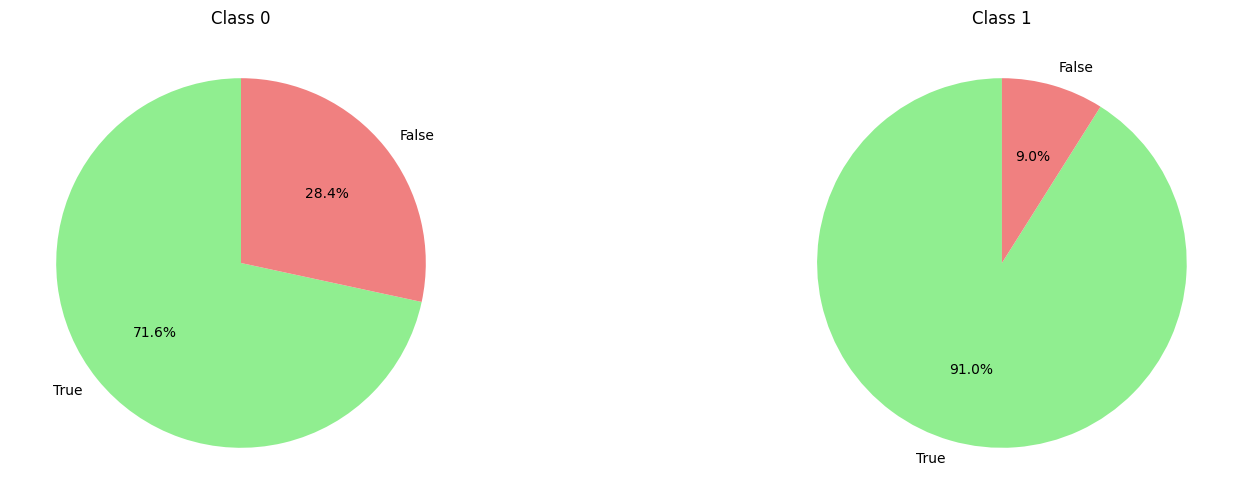

In [66]:
plot_pie_charts(y_test.values, y_pred)

In [67]:
results_df.loc[len(results_df)] = ["MLP", logloss, accuracy]
results_df

,Model,LogLoss,Accuracy
0,Logistic Regression,0.615467,0.69450
1,Balanced Logistic Regression,0.693183,0.50100
2,Poly Logistic Regression,0.613024,0.69450
3,Balanced Poly Logistic Regression,0.690083,0.51565
4,MLP,0.333628,0.85110


In [68]:
# df = generate_quadrilateral_dataset(10000, xy_range=(-1000, 1000))
# X_l = df.drop(columns=['label'])
# y_l = df['label']
test_dataset_l = MyDataset(X_l.values, y_l.values)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=BATCH_SIZE, shuffle=False)

y_true = []
y_pred = []
y_pred_probs = []
with torch.no_grad():
    for X_batch, y_batch in test_dataloader_l:
        X_batch = X_batch.type(torch.float32)
        y_batch = y_batch.float().reshape(-1, 1)

        predictions = model(X_batch)
        y_pred_probs.extend(predictions.numpy())
        y_true.extend(y_batch.cpu().numpy().flatten())

logloss = log_loss(y_true, y_pred_probs)
y_pred = (np.array(y_pred_probs) > 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)
print(f"Test LogLoss: {logloss}")
print(f"Test Accuracy: {accuracy}")

Test LogLoss: 4.789603140732416
Test Accuracy: 0.84475


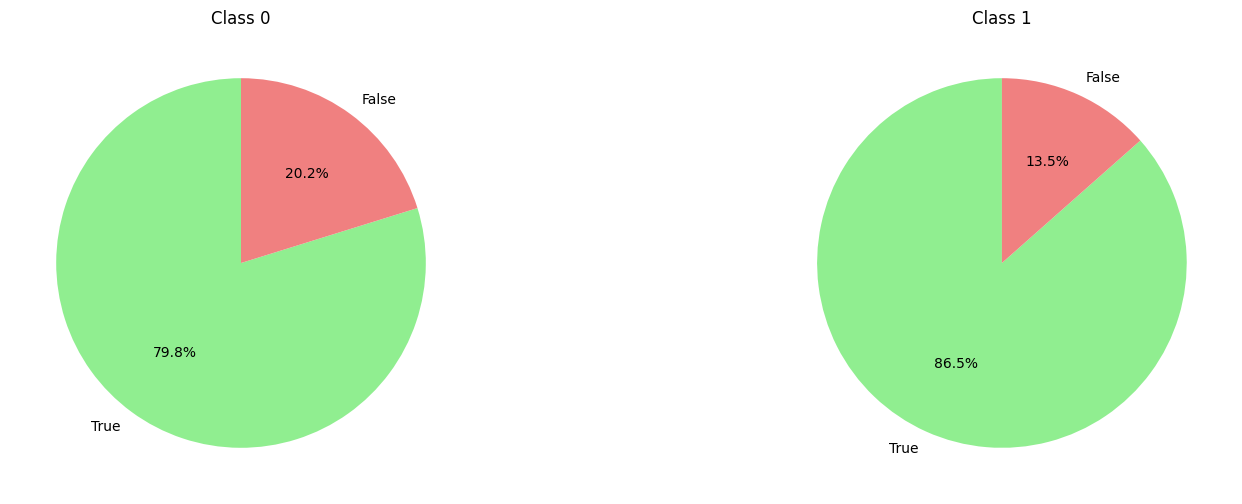

In [69]:
plot_pie_charts(y_l.values, y_pred)

So MLP model is more stable to generalization!

# 6. Using GPU

 One of the most critical aspects of deep learning is <font color='red'>**the utilization of GPUs**.</font> Neural networks often deal with massive datasets, and GPUs significantly accelerate the training and inference processes.

To utilize GPU acceleration:

*   Navigate to `Runtime` -> `Change runtime type`
*   Then select `T4 GPU`.

Please  note that this change <ins>will require you to re-execute all cells</ins> in the notebook.

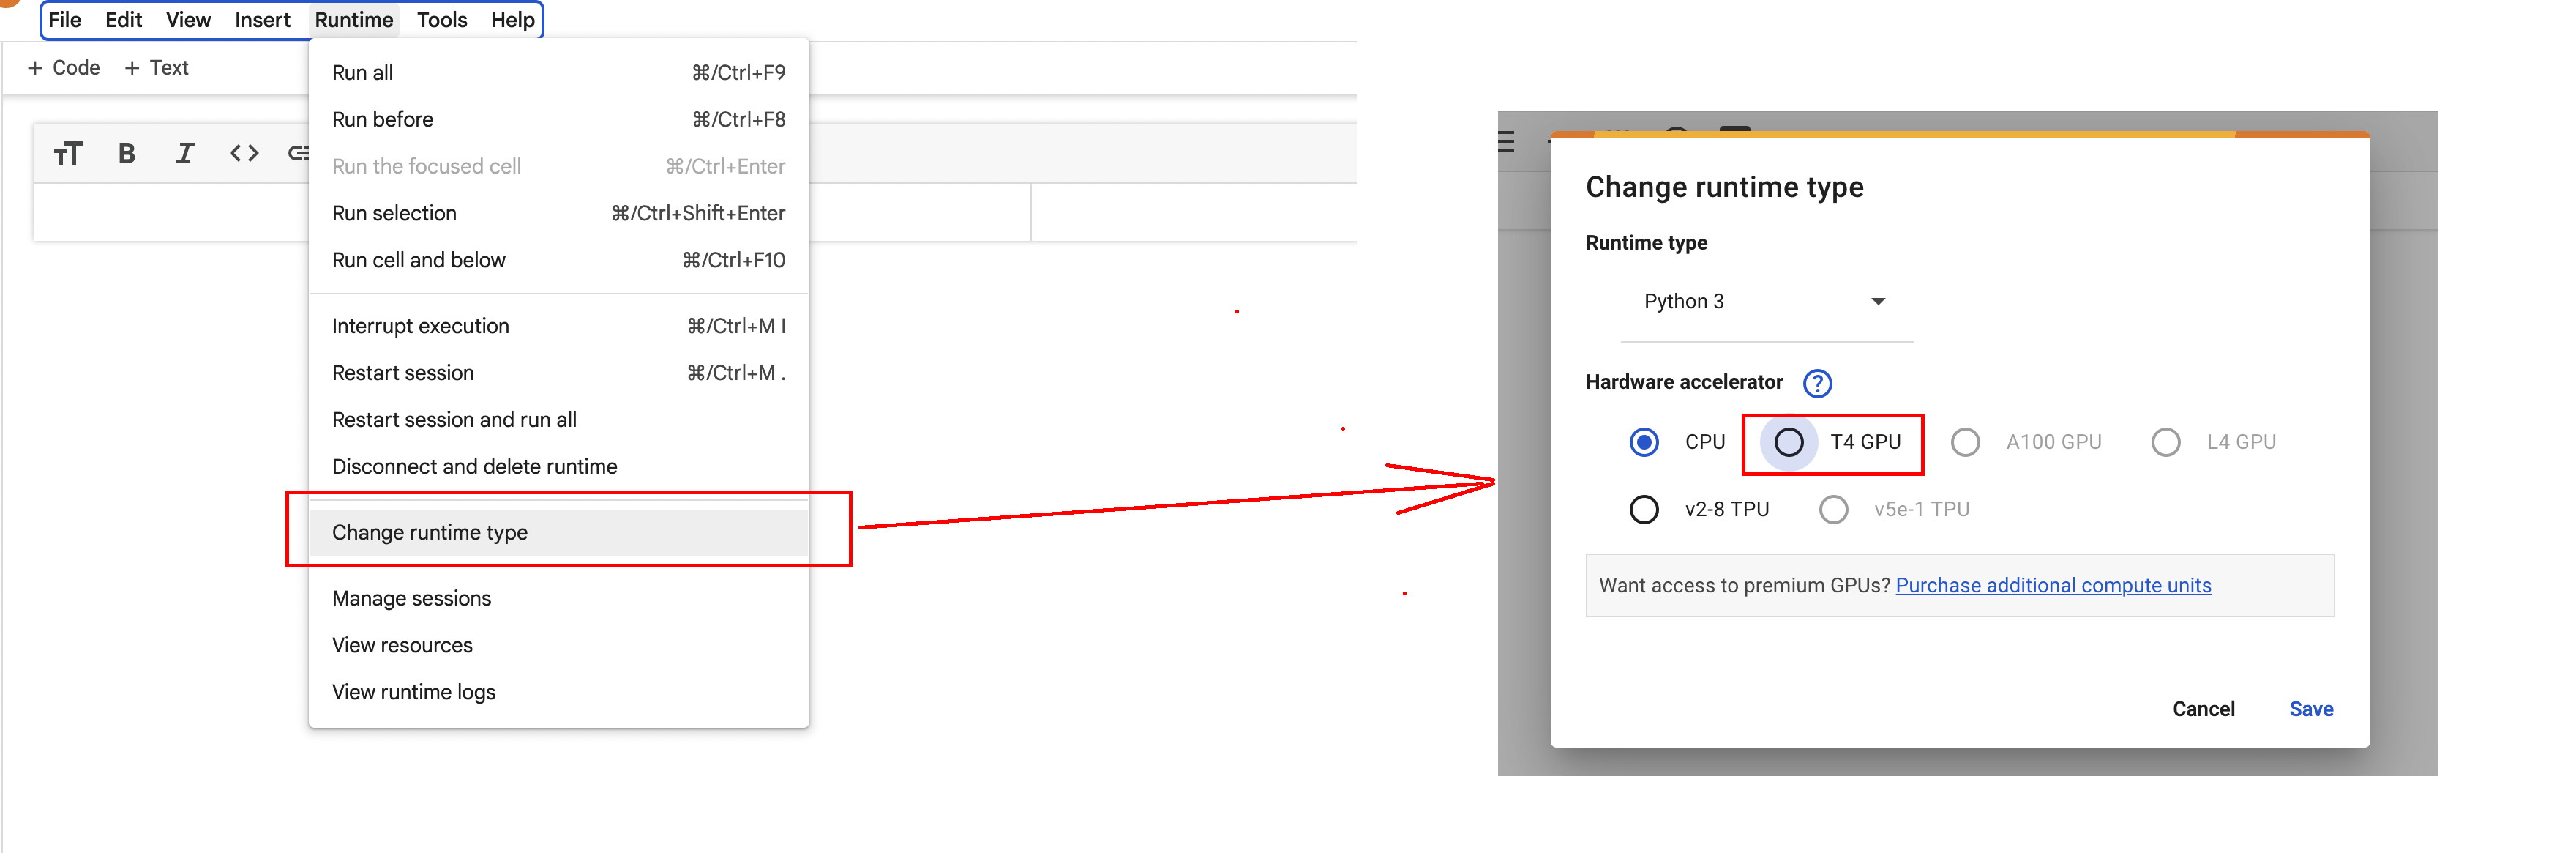

Check the device

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The device for training or inference can be either CPU or GPU. Both the model and all tensors should reside on the same device (CPU or GPU). This can be easily achieved using the following command:

```
model = model.to(device)
tensor = tensor.to(device)
```



For  convenience we repeat the code from above.

# Dataset creation (NO NEW CODE)

In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt
import time
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
%matplotlib inline
# Fix the seed and the random state
seed=42
random_state=42

In [ ]:
def is_convex_quad(points):

    def cross(a, b, c):
        ab = (b[0] - a[0], b[1] - a[1])
        bc = (c[0] - b[0], c[1] - b[1])
        return ab[0] * bc[1] - ab[1] * bc[0]

    signs = []
    n = 4
    for i in range(n):
        a, b, c = points[i], points[(i + 1) % n], points[(i + 2) % n]
        z = cross(a, b, c)
        signs.append(np.sign(z))

    signs = [s for s in signs if s != 0]
    return all(s > 0 for s in signs) or all(s < 0 for s in signs)


def generate_quadrilateral_dataset(n_samples=1000, xy_range=(-10, 10), random_state=None):

    if random_state:
        np.random.seed(random_state)

    data = []
    for _ in range(n_samples):
        points = np.random.uniform(xy_range[0], xy_range[1], size=(4, 2))
        label = int(is_convex_quad(points))
        flat_points = points.flatten().tolist()
        data.append(flat_points + [label])

    columns = [f'{coord}{i+1}' for i in range(4) for coord in ['x', 'y']] + ['label']
    df = pd.DataFrame(data, columns=columns)
    return df

# Example Usage
df = generate_quadrilateral_dataset(100000,random_state=random_state)
X = df.drop(columns=['label'])
y = df['label']

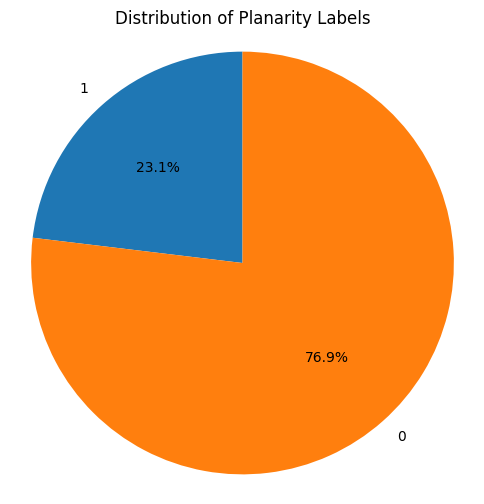

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each label (0 and 1)
label_counts = {}
for label in y:
    label_counts[label] = label_counts.get(label, 0) + 1

# Extract labels and counts for the pie chart
labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Planarity Labels')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logloss_logreg = log_loss(y_test, logreg.predict_proba(X_test))
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(accuracy_logreg)

0.76905


In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32

# Create dataset and dataloader
train_dataset = MyDataset(X_train.values, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = MyDataset(X_test.values, y_test.values)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model training (NEW CODE)

We added the following new things:

1. **GPU Utilization**: Leveraging GPU acceleration for faster training.
2. **Evaluation Metrics**: Calculation of test loss and accuracy during each epoch for comprehensive model assessment.
3. **Model Weight Saving**: Regular saving of model weights to mitigate the risk of data loss due to potential interruptions, such as disconnections from Google Colab.


In [ ]:
X_train.shape[1]

8

cuda


  5%|▌         | 1/20 [00:06<02:06,  6.67s/it]

Saved best model to model_weights/best_model_epoch_0.pth


 10%|█         | 2/20 [00:11<01:44,  5.79s/it]

Saved best model to model_weights/best_model_epoch_1.pth


 15%|█▌        | 3/20 [00:16<01:30,  5.33s/it]

Saved best model to model_weights/best_model_epoch_2.pth


 20%|██        | 4/20 [00:21<01:24,  5.28s/it]

Saved best model to model_weights/best_model_epoch_3.pth


 25%|██▌       | 5/20 [00:26<01:16,  5.12s/it]

Saved best model to model_weights/best_model_epoch_4.pth


 30%|███       | 6/20 [00:32<01:17,  5.53s/it]

Saved best model to model_weights/best_model_epoch_5.pth


 35%|███▌      | 7/20 [00:37<01:09,  5.35s/it]

Saved best model to model_weights/best_model_epoch_6.pth


 40%|████      | 8/20 [00:42<01:02,  5.20s/it]

Saved best model to model_weights/best_model_epoch_7.pth


 50%|█████     | 10/20 [00:52<00:50,  5.06s/it]

Saved best model to model_weights/best_model_epoch_9.pth


 70%|███████   | 14/20 [01:12<00:30,  5.04s/it]

Saved best model to model_weights/best_model_epoch_13.pth


 75%|███████▌  | 15/20 [01:17<00:24,  4.99s/it]

Saved best model to model_weights/best_model_epoch_14.pth


 90%|█████████ | 18/20 [01:33<00:10,  5.08s/it]

Saved best model to model_weights/best_model_epoch_17.pth


100%|██████████| 20/20 [01:42<00:00,  5.14s/it]

Saved best model to model_weights/best_model_epoch_19.pth


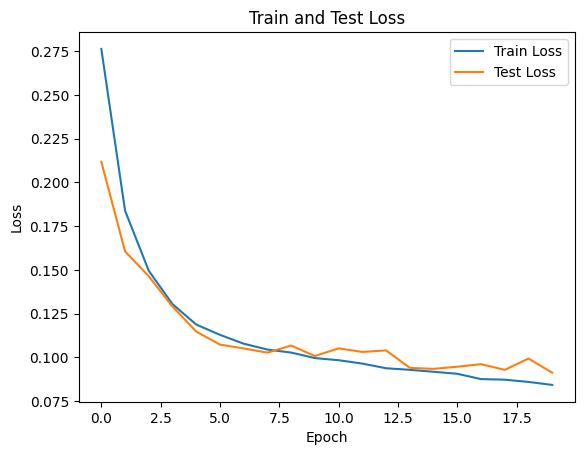

In [ ]:
# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define a directory to save model weights
model_dir = "model_weights"
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
mlp = MLP(input_size, hidden_size, output_size)
mlp = mlp.to(device) # GPU
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
test_losses = []
best_test_loss = float('inf') # Initialize with a very high value
best_epoch = 0

for epoch in tqdm(range(num_epochs)):
    # Training
    mlp.train()  # Set the model to training mode
    epoch_train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(inputs.shape[0], -1).float()
        labels = labels.float().reshape(-1, 1)
        # Move to device (GPU)
        inputs = inputs.to(device) # GPU
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Testing
    mlp.eval()  # Set the model to evaluation mode
    epoch_test_loss = 0
    with torch.no_grad():  # Disable gradient calculations for testing
        for inputs, labels in test_loader:
            inputs = inputs.reshape(inputs.shape[0], -1).float()
            labels = labels.float().reshape(-1, 1)


            # Move to device (GPU)
            inputs = inputs.to(device) # GPU
            labels = labels.to(device)


            outputs = mlp(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
    test_losses.append(epoch_test_loss / len(test_loader))

    # Save the model if it's the best so far
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_epoch = epoch
        model_path = os.path.join(model_dir, f"best_model_epoch_{epoch}.pth")
        torch.save(mlp.state_dict(), model_path)
        print(f"Saved best model to {model_path}")

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

<font color='Blue'>**How long should we train the model?**</font>  Neural networks are highly susceptible to overfitting. To prevent overfitting, it is generally advisable to <ins>select the model with the lowest test score</ins> observed during training.


In [ ]:
# Load the best model weights
best_model_path = os.path.join(model_dir, f"best_model_epoch_{best_epoch}.pth")
mlp.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

Loaded best model from model_weights/best_model_epoch_19.pth


In [ ]:
mlp.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.reshape(inputs.shape[0], -1).float()
        inputs = inputs.to(device)
        outputs = mlp(inputs)
        y_pred_prob.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
logloss_mlp = log_loss(y_true, y_pred_prob)
accuracy_mlp = accuracy_score(y_true, y_pred)


print(f"Logistic Regression Log Loss: {logloss_logreg:.4f}, Accuracy: {accuracy_logreg:.4f}")
print(f"MLP Log Loss: {logloss_mlp:.4f}, Accuracy: {accuracy_mlp:.4f}")

Logistic Regression Log Loss: 0.5406, Accuracy: 0.7691
MLP Log Loss: 0.0912, Accuracy: 0.9614


# Network Architecture

Why do we study Neural Networks? A fundamental reason for the success of neural networks is the **Universal Approximation Theorem** (for details see https://en.wikipedia.org/wiki/Universal_approximation_theorem). One of the version states:

 > Feedforward networks with non-polynomial activation functions are dense in the space of continuous functions between two Euclidean spaces.

Note that these theorems do not guarantee that any specific network size, such as 10,000 neurons, will suffice.

As an experiment, let's construct a substantially larger neural network and examine its performance characteristics.

## Big NN

In [ ]:
input_size, hidden_size, output_size = 8, 100, 1

big_model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Sigmoid()
)

Let's train it.

100%|██████████| 20/20 [02:08<00:00,  6.42s/it]

20 20


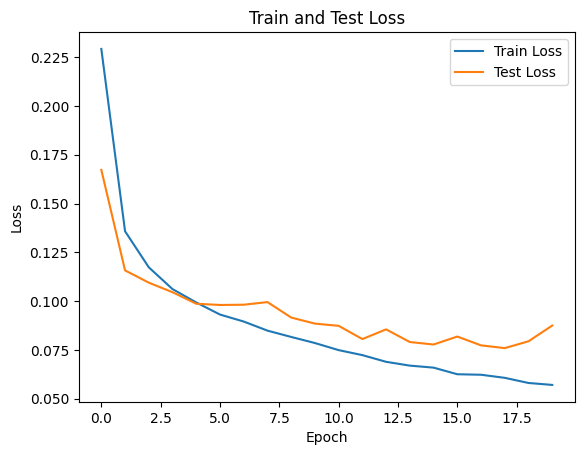

In [ ]:
def train_model(model):
    model = model.to(device) # GPU
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(big_model.parameters(), lr=0.001)

    num_epochs = 20
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Training
        model.train()  # Set the model to training mode
        epoch_train_loss = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.reshape(inputs.shape[0], -1).float()
            labels = labels.float().reshape(-1, 1)
            # Move to device (GPU)
            inputs = inputs.to(device) # GPU
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Testing
        model.eval()  # Set the model to evaluation mode
        epoch_test_loss = 0
        with torch.no_grad():  # Disable gradient calculations for testing
            for inputs, labels in test_loader:
                inputs = inputs.reshape(inputs.shape[0], -1).float()
                labels = labels.float().reshape(-1, 1)

                # Move to device (GPU)
                inputs = inputs.to(device) # GPU
                labels = labels.to(device)


                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()
        test_losses.append(epoch_test_loss / len(test_loader))

    print(len(train_losses), len(test_losses))
    # Plot the losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Test Loss')
    plt.show()

train_model(big_model)

We get the following results.

In [ ]:
def eval_model(model):
    model.eval()
    y_pred_prob = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.reshape(inputs.shape[0], -1).float()
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred_prob.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
    logloss = log_loss(y_true, y_pred_prob)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Log Loss: {logloss:.4f}, Accuracy: {accuracy:.4f}")

eval_model(big_model)

Log Loss: 0.0875, Accuracy: 0.9654


## Gradient vanishing and explition

Consider the multiplication of diagonal matrices: $$W = W_1 W_2 \dots W_n.$$ If the eigenvalues of each $W_i$ are less than 1, then the product $W$ will quickly converge to a small matrix. Conversely, if the eigenvalues of each $W_i$  are greater than 1, the product $W$ will grow exponentially.

With Neural Networks it lead to the idea, that on each layers *parameters* and *gradients* should ideally be kept within a reasonable range or normalized.

### Initialization of Layers

Here are a few tips for initializing layer weights:

1. **Default Initialization**: Often, you don't need to explicitly initialize weights; PyTorch may provide reasonable defaults.
2. **He Initialization**: A common approach is to initialize weights within the range $[-y, y]$, where $y = \frac{1}{\sqrt{n}}$ and 'n' is the number of inputs to a neuron.
3. **Xavier Initialization**: Xavier initialization is theoretically well-founded in certain situations ([Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).

PyTorch Docs:
https://pytorch.org/docs/stable/nn.init.html#torch-nn-init
